In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from typing import Optional, Union

data = pd.read_csv('data.csv', index_col='entry_id')
element_types = pd.read_csv('element_types.csv', index_col='id')
players = pd.read_csv('players.csv', index_col='id')
teams = pd.read_csv('teams.csv', index_col='id')

In [18]:
print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4192 entries, 1 to 4264
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   player_id                     4192 non-null   int64  
 1   event_id                      4192 non-null   int64  
 2   timestamp                     4192 non-null   object 
 3   chance_of_playing_this_round  3136 non-null   float64
 4   form                          4192 non-null   float64
 5   status                        4192 non-null   object 
 6   fixture_code                  4192 non-null   int64  
 7   opposition_gf                 4192 non-null   float64
 8   opposition_ga                 4192 non-null   float64
 9   opposition                    4192 non-null   int64  
 10  is_home                       4192 non-null   int64  
 11  kickoff_time                  4192 non-null   object 
 12  points_h                      4186 non-null   float64
 13  poi

,player_id,event_id,timestamp,chance_of_playing_this_round,form,status,fixture_code,opposition_gf,opposition_ga,opposition,...,threat_h,threat_a,points_1,points_2,points_3,minutes_1,minutes_2,minutes_3,opposition_strength,response
entry_id,,,,,,,,,,,,,,,,,,,,,
1,1,33,2021-04-23 14:46:16,0.0,0.0,u,319,1.19,1.48,7,...,0.00,0.00,0,0,0,0.0,0.0,0.0,3.0,0
2,2,33,2021-04-23 14:46:16,0.0,0.0,u,319,1.19,1.48,7,...,0.00,0.00,0,0,0,0.0,0.0,0.0,3.0,0
3,3,33,2021-04-23 14:46:16,0.0,0.0,i,319,1.19,1.48,7,...,3.31,4.38,0,0,0,0.0,0.0,0.0,3.0,0
4,4,33,2021-04-23 14:46:16,75.0,0.7,i,319,1.19,1.48,7,...,25.62,20.06,0,0,2,0.0,0.0,76.0,3.0,0
5,5,33,2021-04-23 14:46:16,100.0,0.0,a,319,1.19,1.48,7,...,2.69,1.44,0,0,0,0.0,0.0,45.0,3.0,0


In [19]:
print(element_types.info())

element_types.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 1 to 4
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   singular_name  4 non-null      object
dtypes: object(1)
memory usage: 64.0+ bytes
None


,singular_name
id,
1,Goalkeeper
2,Defender
3,Midfielder
4,Forward


In [20]:
print(players.info())

players.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 1 to 649
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team          713 non-null    int64  
 1   element_type  713 non-null    int64  
 2   first_name    713 non-null    object 
 3   second_name   713 non-null    object 
 4   web_name      713 non-null    object 
 5   now_cost      713 non-null    int64  
 6   initial_cost  713 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 44.6+ KB
None


,team,element_type,first_name,second_name,web_name,now_cost,initial_cost
id,,,,,,,
1,1,3,Mesut,Özil,Özil,67,70.0
2,1,2,Sokratis,Papastathopoulos,Sokratis,48,50.0
3,1,2,David,Luiz Moreira Marinho,David Luiz,54,55.0
4,1,3,Pierre-Emerick,Aubameyang,Aubameyang,113,120.0
5,1,2,Cédric,Soares,Cédric,46,50.0


In [21]:
print(teams.info())

teams.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 20
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        20 non-null     object
 1   short_name  20 non-null     object
 2   strength    20 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 640.0+ bytes
None


,name,short_name,strength
id,,,
1,Arsenal,ARS,4
2,Aston Villa,AVL,3
3,Brighton,BHA,3
4,Burnley,BUR,2
5,Chelsea,CHE,4


In [22]:
train_data = data[data.event_id < 38]
test_data = data[data.event_id == 38]

print("Training data entries:", train_data.shape[0])
print("Test data entries:", test_data.shape[0])

Training data entries: 3486
Test data entries: 706


In [23]:
removed_cols = ['timestamp', 'fixture_code', 'kickoff_time', 'opposition', 'event_id']

for col in removed_cols:
    del train_data[col]
    del test_data[col]

<AxesSubplot:xlabel='response', ylabel='Count'>

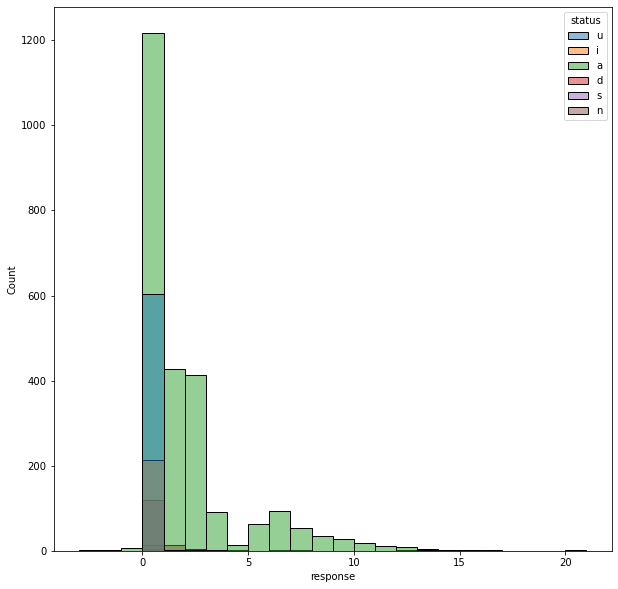

In [24]:


plt.figure(figsize=(10, 10))
sns.histplot(x=train_data.response, hue=train_data.status, binwidth=1)



<AxesSubplot:xlabel='response', ylabel='Density'>

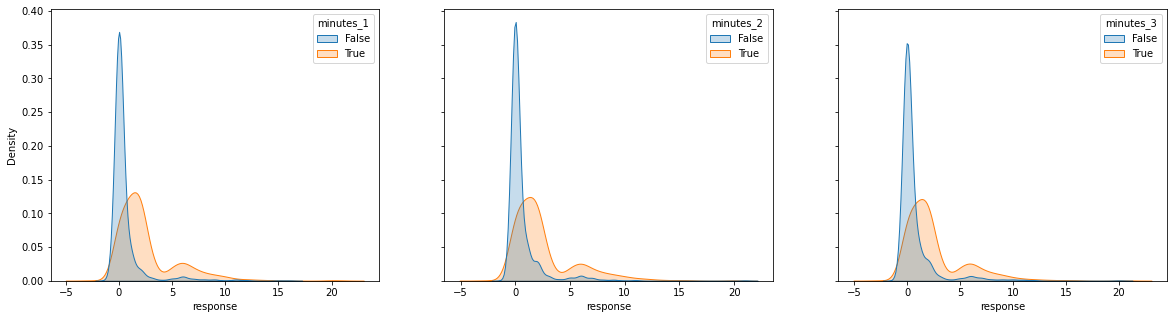

In [25]:
played_match_1 = train_data[train_data.status == 'a']["minutes_1"] > 0
played_match_2 = train_data[train_data.status == 'a']["minutes_2"] > 0
played_match_3 = train_data[train_data.status == 'a']["minutes_3"] > 0

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
sns.kdeplot(x=train_data[train_data.status == 'a'].response, hue=played_match_1, shade=True, ax=ax[0])
sns.kdeplot(x=train_data[train_data.status == 'a'].response, hue=played_match_2, shade=True, ax=ax[1])
sns.kdeplot(x=train_data[train_data.status == 'a'].response, hue=played_match_3, shade=True, ax=ax[2])

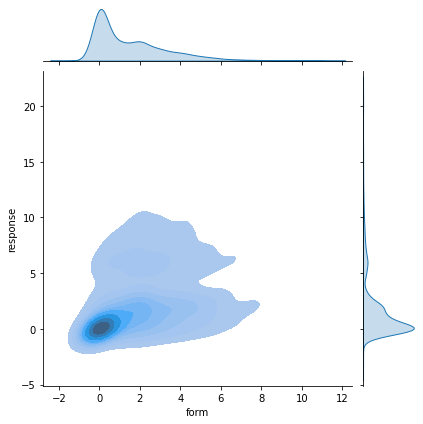

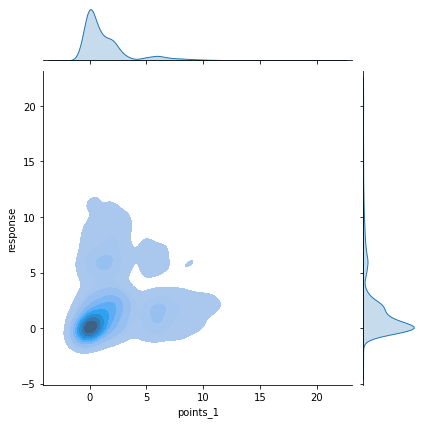

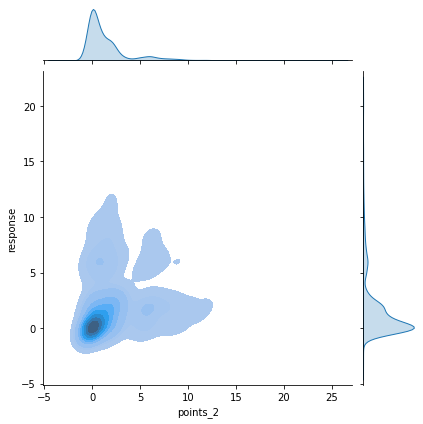

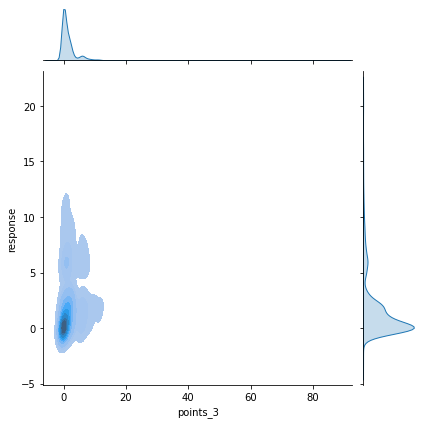

In [26]:
available_players = train_data[train_data.status == 'a'].copy()

sns.jointplot(x=available_players.form, y=available_players.response, kind='kde', fill=True)
sns.jointplot(x=available_players.points_1, y=available_players.response, kind='kde', fill=True)
sns.jointplot(x=available_players.points_2, y=available_players.response, kind='kde', fill=True)
sns.jointplot(x=available_players.points_3, y=available_players.response, kind='kde', fill=True)

<AxesSubplot:xlabel='response', ylabel='Count'>

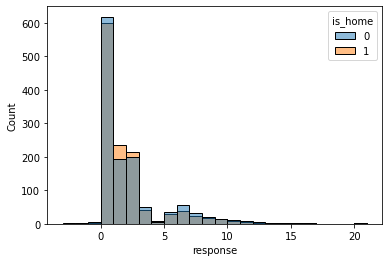

In [27]:
sns.histplot(x=available_players.response, hue=available_players.is_home, binwidth=1)

In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3486 entries, 1 to 3558
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   player_id                     3486 non-null   int64  
 1   chance_of_playing_this_round  2609 non-null   float64
 2   form                          3486 non-null   float64
 3   status                        3486 non-null   object 
 4   opposition_gf                 3486 non-null   float64
 5   opposition_ga                 3486 non-null   float64
 6   is_home                       3486 non-null   int64  
 7   points_h                      3482 non-null   float64
 8   points_a                      3482 non-null   float64
 9   minutes_h                     3482 non-null   float64
 10  minutes_a                     3482 non-null   float64
 11  goals_scored_h                3482 non-null   float64
 12  goals_scored_a                3482 non-null   float64
 13  ass

In [29]:
train_data = pd.get_dummies(train_data)
test_data  = pd.get_dummies(test_data)

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3486 entries, 1 to 3558
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   player_id                     3486 non-null   int64  
 1   chance_of_playing_this_round  2609 non-null   float64
 2   form                          3486 non-null   float64
 3   opposition_gf                 3486 non-null   float64
 4   opposition_ga                 3486 non-null   float64
 5   is_home                       3486 non-null   int64  
 6   points_h                      3482 non-null   float64
 7   points_a                      3482 non-null   float64
 8   minutes_h                     3482 non-null   float64
 9   minutes_a                     3482 non-null   float64
 10  goals_scored_h                3482 non-null   float64
 11  goals_scored_a                3482 non-null   float64
 12  assists_h                     3482 non-null   float64
 13  ass

In [30]:
def fill_values(df):
    df['chance_of_playing_this_round'] = df['chance_of_playing_this_round'].fillna(100)
    df.fillna(0, inplace=True)
    
fill_values(train_data)
fill_values(test_data)

train_data.head()

,player_id,chance_of_playing_this_round,form,opposition_gf,opposition_ga,is_home,points_h,points_a,minutes_h,minutes_a,...,minutes_2,minutes_3,opposition_strength,response,status_a,status_d,status_i,status_n,status_s,status_u
entry_id,,,,,,,,,,,,,,,,,,,,,
1,1,0.0,0.0,1.19,1.48,1,0.00,0.00,0.00,0.00,...,0.0,0.0,3.0,0,0,0,0,0,0,1
2,2,0.0,0.0,1.19,1.48,1,0.00,0.00,0.00,0.00,...,0.0,0.0,3.0,0,0,0,0,0,0,1
3,3,0.0,0.0,1.19,1.48,1,1.62,0.88,41.69,42.31,...,0.0,0.0,3.0,0,0,0,1,0,0,0
4,4,75.0,0.7,1.19,1.48,1,4.06,2.69,65.88,59.56,...,0.0,76.0,3.0,0,0,0,1,0,0,0
5,5,100.0,0.0,1.19,1.48,1,1.31,0.44,25.62,20.88,...,0.0,45.0,3.0,0,1,0,0,0,0,0


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3486 entries, 1 to 3558
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   player_id                     3486 non-null   int64  
 1   chance_of_playing_this_round  3486 non-null   float64
 2   form                          3486 non-null   float64
 3   opposition_gf                 3486 non-null   float64
 4   opposition_ga                 3486 non-null   float64
 5   is_home                       3486 non-null   int64  
 6   points_h                      3486 non-null   float64
 7   points_a                      3486 non-null   float64
 8   minutes_h                     3486 non-null   float64
 9   minutes_a                     3486 non-null   float64
 10  goals_scored_h                3486 non-null   float64
 11  goals_scored_a                3486 non-null   float64
 12  assists_h                     3486 non-null   float64
 13  ass

In [32]:


del train_data['player_id']



In [33]:


features = list(train_data.columns)
features.remove('response')
X_train, y_train = train_data[features].values, train_data['response'].values
print(X_train.shape)
print(y_train.shape)



(3486, 42)
(3486,)


In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print(X_train)

[[-1.71051321 -0.67919577 -0.63486191 ... -0.04152274 -0.06350006
   2.18657141]
 [-1.71051321 -0.67919577 -0.63486191 ... -0.04152274 -0.06350006
   2.18657141]
 [-1.71051321 -0.67919577 -0.63486191 ... -0.04152274 -0.06350006
  -0.457337  ]
 ...
 [ 0.61169458 -0.67919577 -1.22087037 ... -0.04152274 -0.06350006
  -0.457337  ]
 [ 0.61169458  0.84338809 -1.22087037 ... -0.04152274 -0.06350006
  -0.457337  ]
 [ 0.61169458 -0.67919577 -1.22087037 ... -0.04152274 -0.06350006
  -0.457337  ]]


In [35]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [36]:
player_ids = test_data['player_id'].values 
del test_data['player_id']
X_test, y_test = test_data[features].values, test_data['response'].values
X_test = scaler.transform(X_test)

In [37]:
def model_to_predictions(model):
    predictions = model.predict(X_test)
    predictions = [[player_ids[i], predictions[i], y_test[i]] for i in range(len(player_ids))]
    predictions = pd.DataFrame(predictions, columns=['id', 'prediction', 'actual']).set_index('id')
    predictions = predictions.join(players, on='id')
    return predictions

model_to_predictions(model1).sort_values('prediction', ascending=False).head(40)

,prediction,actual,team,element_type,first_name,second_name,web_name,now_cost,initial_cost
id,,,,,,,,,
254,7.156192,6,11,3,Mohamed,Salah,Salah,129,120.0
302,6.024959,0,13,3,Bruno Miguel,Borges Fernandes,Fernandes,113,105.0
251,5.517780,16,11,3,Sadio,Mané,Mané,118,120.0
390,5.484668,5,17,3,Heung-Min,Son,Son,96,90.0
259,5.125098,5,11,2,Trent,Alexander-Arnold,Alexander-Arnold,78,75.0
388,5.100475,10,17,4,Harry,Kane,Kane,119,105.0
203,4.996898,5,10,3,Jack,Harrison,Harrison,56,55.0
91,4.752765,2,4,4,Chris,Wood,Wood,66,65.0
4,4.718475,3,1,3,Pierre-Emerick,Aubameyang,Aubameyang,113,120.0


In [38]:
model1.score(X_test, y_test)

0.2634161059937019

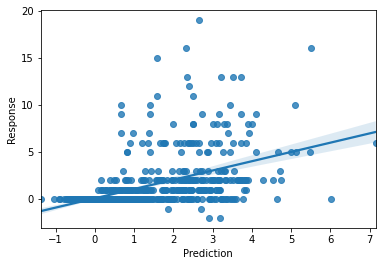

In [39]:
def plot_predictions(model):
    sns.regplot(x=model.predict(X_test), y=y_test)
    plt.xlabel('Prediction')
    plt.ylabel('Response')
    
plot_predictions(model1)

In [40]:


model2 = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=5)
model2.fit(X_train, y_train)



RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=500)

In [41]:

model_to_predictions(model2).sort_values('prediction', ascending=False).head(40)


,prediction,actual,team,element_type,first_name,second_name,web_name,now_cost,initial_cost
id,,,,,,,,,
254,5.569662,6,11,3,Mohamed,Salah,Salah,129,120.0
302,5.274538,0,13,3,Bruno Miguel,Borges Fernandes,Fernandes,113,105.0
483,5.205716,9,15,1,Aaron,Ramsdale,Ramsdale,46,50.0
203,4.948564,5,10,3,Jack,Harrison,Harrison,56,55.0
89,4.807597,2,4,3,Ashley,Westwood,Westwood,53,55.0
251,4.709843,16,11,3,Sadio,Mané,Mané,118,120.0
492,4.635325,8,10,4,Rodrigo,Moreno,Rodrigo,57,60.0
91,4.623657,2,4,4,Chris,Wood,Wood,66,65.0
370,4.598388,2,16,3,James,Ward-Prowse,Ward-Prowse,59,60.0


In [30]:
model2.score(X_test, y_test)

0.25549886716433334

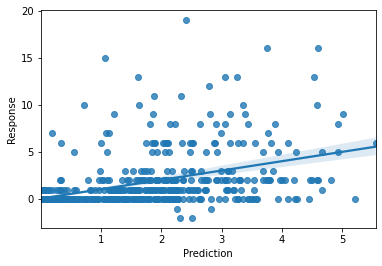

In [31]:


plot_predictions(model2)

